In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 1000000 

%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)


!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#읍면동 리스트
sample = pd.read_csv('/content/drive/MyDrive/Sejong/2.세종시_표제부.csv')
sample['읍면동'] = sample['대지위치'].str.replace('세종특별자치시 ','')
sample['읍면동'] = sample['읍면동'].str.replace('조치원읍 ','조치원읍')
sample[['1', '2','3']] = sample['읍면동'].str.split(' ', n=2, expand=True)
sample['2'] = sample['2'].str.replace('조치원읍','조치원읍 ')
list_d = list(set(sample['2']))

#조치원읍 없는 버전
list_without = []
for i in list_d :
  if '조치원읍 ' in i :
    pass;
  else :
    list_without.append(i)

dataset = pd.DataFrame(list_without,columns={'읍면동'})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def make_rentfee_df(a,b,c) :
  df = pd.read_csv(a)
  df['보증금(만원)'] = df['보증금(만원)'].str.replace(',','')
  df = df.astype({'보증금(만원)' : float, '계약년월' : 'str'})
  df['시군구'] = df['시군구'].str.replace('세종특별자치시 ','')
  df.replace({'전세' : 'j', '월세' : 'm'},inplace=True)
  
  df_j = make_rentfee_data(df,b,'j')
  df_m = make_rentfee_data(df,b,'m')
  
  d = pd.merge(c,df_j, how='outer',on='읍면동')
  f = pd.merge(d,df_m, how='outer',on='읍면동')

  return f

def make_rentfee_data(i, b, c) :

  df = i[i['전월세구분'] == c]
  df[['읍면동', '2']] = df['시군구'].str.split(' ', n=1, expand=True)

  df = df.groupby(['읍면동']).agg({'계약일' : 'count', '보증금(만원)':'mean'})
  x = c+'_'+b+'_count'
  y = c+'_'+b+'_price'
  
  df.columns = [x,y]

  return df

In [5]:
office = make_rentfee_df('/content/drive/MyDrive/Sejong/10.세종시_오피스텔(전월세)_실거래가.csv','office',dataset)
apt = make_rentfee_df('/content/drive/MyDrive/Sejong/7.세종시_아파트(전월세)_실거래가.csv','apt',dataset)
ali = make_rentfee_df('/content/drive/MyDrive/Sejong/8.세종시_연립다세대(전월세)_실거래가.csv','ali',dataset)
# 단독주택 제외 >> 대지단위(명확하게 비교하기가 어려움)
summary = pd.merge(office, apt, how='outer', on='읍면동')
summary = pd.merge(summary, ali, how='outer', on='읍면동')
summary.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,읍면동,j_office_count,j_office_price,m_office_count,m_office_price,j_apt_count,j_apt_price,m_apt_count,m_apt_price,j_ali_count,j_ali_price,m_ali_count,m_ali_price
0,연기면,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6500.0,3.0,933.333333
1,해밀동,NaN,NaN,NaN,NaN,72.0,30673.611111,27.0,5074.074074,NaN,NaN,NaN,NaN
2,부강면,NaN,NaN,9.0,1222.222222,39.0,5256.410256,18.0,2072.222222,8.0,5625.0,4.0,1125.000000
3,장군면,NaN,NaN,NaN,NaN,10.0,2870.000000,NaN,NaN,1.0,4000.0,NaN,NaN
4,종촌동,NaN,NaN,NaN,NaN,3489.0,17884.719977,2090.0,3887.094737,NaN,NaN,NaN,NaN


In [6]:
market = pd.read_csv('/content/drive/MyDrive/Sejong/14.세종시_상권정보.csv')
ex = pd.DataFrame()

#market divieded
for i in summary['읍면동'] :
  df = market[market['행정동명']==i]
  df = df.groupby('상권업종대분류코드').agg({'상권업종대분류명' : 'count'})
  df= df.transpose()
  df['읍면동'] = i
  list_x = df.iloc[0]

  ex = ex.append(pd.Series(list_x), ignore_index=True)
    
ex02 = pd.merge(summary,ex, how='outer', on='읍면동')
ex02 = ex02.set_index('읍면동')

In [7]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 8]

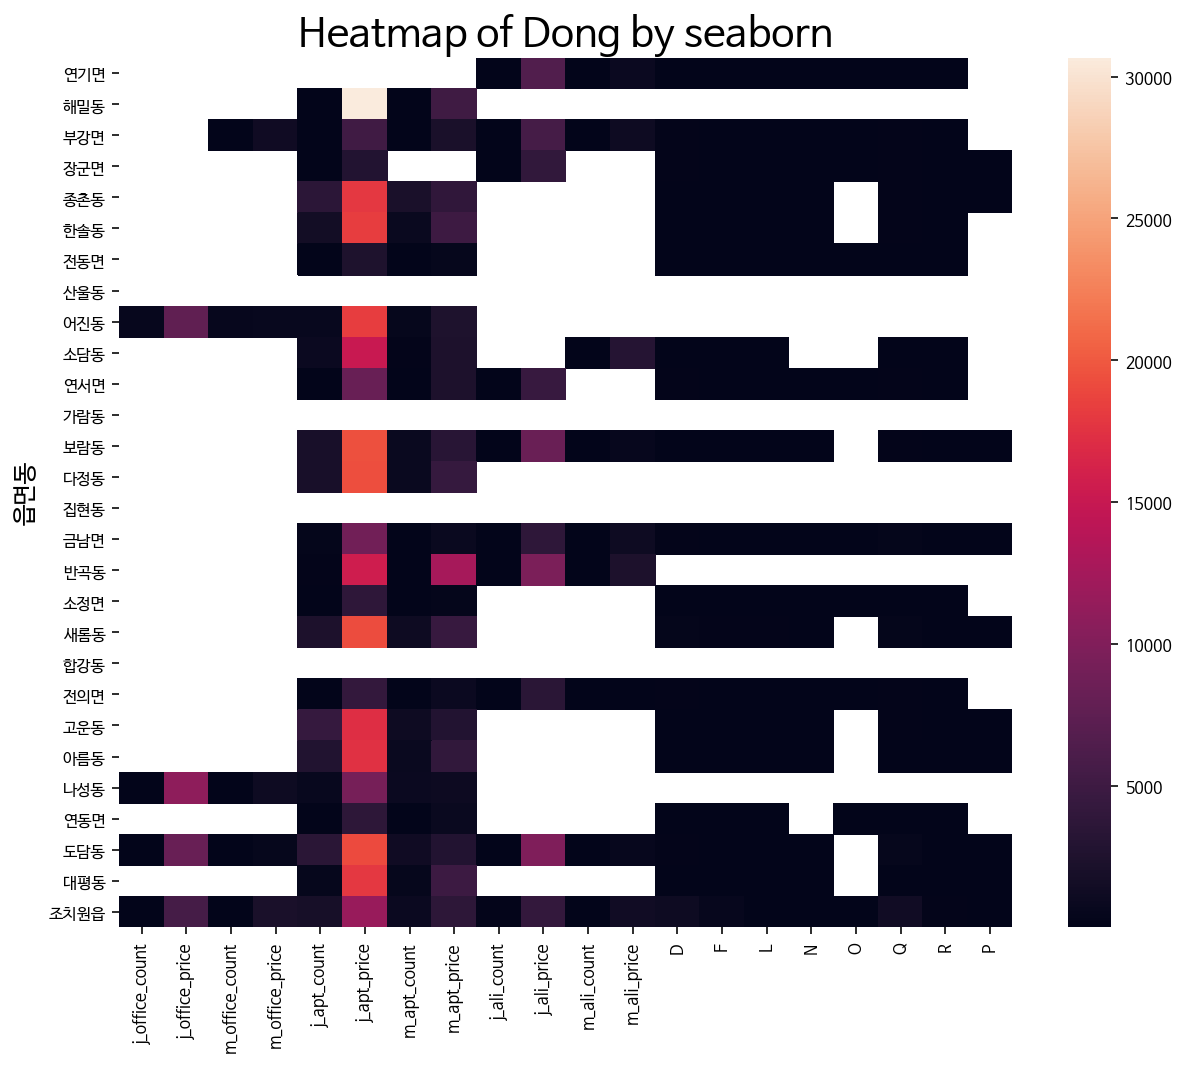

In [8]:
ax = sns.heatmap(ex02)

plt.title('Heatmap of Dong by seaborn', fontsize=20)

plt.show() 

In [9]:
corr = ex02.corr(method = 'pearson')
corr

,j_office_count,j_office_price,m_office_count,m_office_price,j_apt_count,j_apt_price,m_apt_count,m_apt_price,j_ali_count,j_ali_price,m_ali_count,m_ali_price,D,F,L,N,O,Q,R,P
j_office_count,1.000000,-0.126500,0.993327,-0.429414,-0.461736,0.546157,-0.866248,-0.054000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,NaN
j_office_price,-0.126500,1.000000,-0.082434,-0.446877,-0.307970,-0.285094,0.067353,-0.967345,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,NaN
m_office_count,0.993327,-0.082434,1.000000,-0.522907,-0.134603,0.647078,-0.250322,-0.006662,-0.561846,0.977750,0.270199,-0.978782,-0.472909,-0.516122,-0.149933,-0.519515,-1.000000,-0.401454,-0.370673,NaN
m_office_price,-0.429414,-0.446877,-0.522907,1.000000,-0.225691,-0.570419,-0.044778,0.360401,0.900965,-0.951096,0.249123,0.949547,0.851040,0.876089,0.625580,0.877995,1.000000,0.806660,0.786492,NaN
j_apt_count,-0.461736,-0.307970,-0.134603,-0.225691,1.000000,0.500528,0.884876,0.127216,0.302068,0.563214,0.848885,-0.256616,0.129453,0.193327,0.162563,0.104330,0.952707,0.196076,0.483743,0.564909
j_apt_price,0.546157,-0.285094,0.647078,-0.570419,0.500528,1.000000,0.438910,0.549277,0.093797,0.845807,0.525371,0.232093,0.021665,0.104853,0.218134,-0.002611,0.704936,0.088400,0.440565,0.599753
m_apt_count,-0.866248,0.067353,-0.250322,-0.044778,0.884876,0.438910,1.000000,0.121650,0.421598,0.444720,0.932200,-0.305316,0.210365,0.245856,0.306779,0.156507,0.964794,0.258068,0.534188,0.264020
m_apt_price,-0.054000,-0.967345,-0.006662,0.360401,0.127216,0.549277,0.121650,1.000000,0.032368,0.618223,-0.065816,0.453476,0.188188,0.238303,0.367585,0.151832,0.857400,0.212660,0.544257,0.307376
j_ali_count,-1.000000,-1.000000,-0.561846,0.900965,0.302068,0.093797,0.421598,0.032368,1.000000,-0.231888,0.628157,0.206514,0.982050,0.993073,0.545039,0.987860,0.986771,0.974794,0.975813,0.182774
j_ali_price,1.000000,1.000000,0.977750,-0.951096,0.563214,0.845807,0.444720,0.618223,-0.231888,1.000000,0.218929,0.265427,-0.243182,-0.216930,-0.328128,-0.236908,-0.128396,-0.142018,-0.064826,0.692629


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


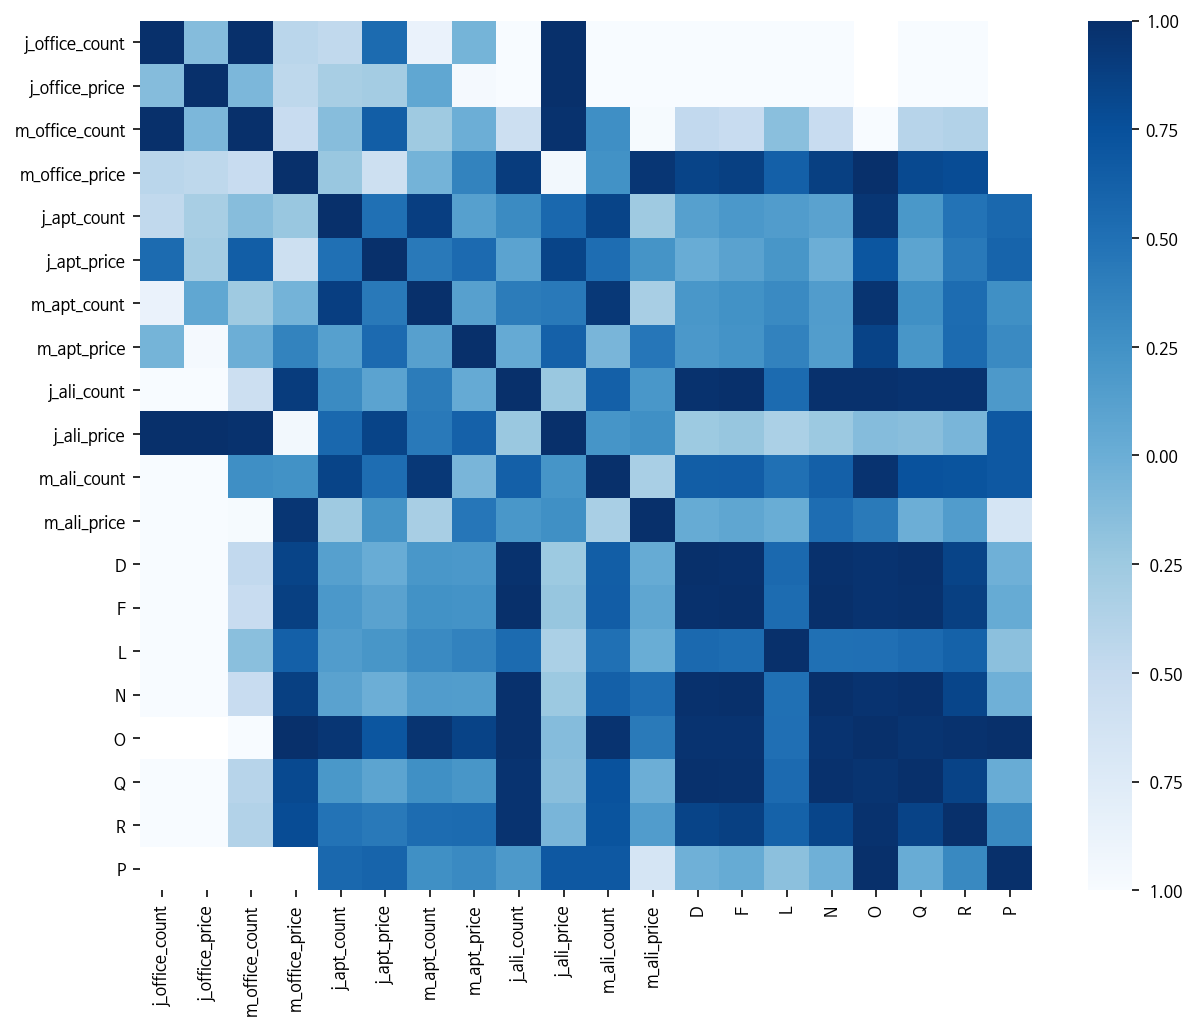

In [11]:
df_heatmap = sns.heatmap(corr,cmap = 'Blues')
